## 1) Import libraries

In [1]:
import torch
import torchvision 
import torch.nn as nn
import numpy as np

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

## 2) Create PyTorch datasets for the training, validation and test splits. 

In [2]:
%%time
image_path = '../../rasbt/data/'
celeba_train_dataset = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', download=False)
celeba_valid_dataset = torchvision.datasets.CelebA(image_path, split='valid', target_type='attr', download=False)
celeba_test_dataset = torchvision.datasets.CelebA(image_path, split='test', target_type='attr', download=False)

CPU times: user 23.4 s, sys: 815 ms, total: 24.2 s
Wall time: 23.6 s


In [4]:
print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))
print('Test set:', len(celeba_test_dataset))

Train set: 162770
Validation set: 19867
Test set: 19962


In [5]:
img, attr = celeba_train_dataset[10]

In [6]:
attr

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [7]:
from torchvision import transforms

5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair 

Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male 

Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks 

Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young 

In [8]:
from torch.utils.data import DataLoader

In [9]:
get_smile = lambda attr: attr[31]

In [10]:
# transform for the training dataset
transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

In [11]:
%%time
celeba_train_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='train', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform_train,
                                                   target_transform=get_smile)

CPU times: user 8.49 s, sys: 259 ms, total: 8.75 s
Wall time: 8.25 s


In [12]:
# transform for the validation and test dataset
transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

In [13]:
%%time
celeba_valid_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='valid', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform,
                                                   target_transform=get_smile)

CPU times: user 7.75 s, sys: 288 ms, total: 8.04 s
Wall time: 7.81 s


In [14]:
%%time
celeba_test_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='test', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform,
                                                   target_transform=get_smile)

CPU times: user 7.66 s, sys: 307 ms, total: 7.97 s
Wall time: 7.81 s


### Grab a subset of the training and validation datasets, just to speed things up.

In [15]:
from torch.utils.data import Subset
celeba_train_dataset = Subset(celeba_train_dataset, torch.arange(16000)) 
celeba_valid_dataset = Subset(celeba_valid_dataset, torch.arange(1000)) 
 
print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))

Train set: 16000
Validation set: 1000


Initialize the DataLoaders for the training, validation and test datasets.

Notice we shuffle the training dataset but not the validation or test datasets.

In [16]:
batch_size = 512

torch.manual_seed(1)
train_dl = DataLoader(celeba_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset, batch_size, shuffle=False)
test_dl = DataLoader(celeba_test_dataset, batch_size, shuffle=False)

## 3) Create the model.

In [17]:
import torch.nn as nn

model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))  
model.add_module('dropout1', nn.Dropout(p=0.5)) 

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))   
model.add_module('dropout2', nn.Dropout(p=0.5)) 

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())        
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))   

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())  


What is the current shape of the model output?

In [18]:
x = torch.ones((4, 3, 64, 64))
model(x).shape

torch.Size([4, 256, 8, 8])

Add some more layers.

In [19]:
model.add_module('pool4', nn.AvgPool2d(kernel_size=8)) 
model.add_module('flatten', nn.Flatten()) 

What is the shape of the output now?

In [20]:
model(x).shape

torch.Size([4, 256])

Add the final output layer.

In [21]:
model.add_module('fc', nn.Linear(256, 1)) 
model.add_module('sigmoid', nn.Sigmoid()) 

What is the final size of the model output?

In [22]:
model(x).shape

torch.Size([4, 1])

In [23]:
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Load the model onto the gpu.

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device) 

In [25]:
device

device(type='cuda')

Set the desired loss and optimzer.

In [26]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
torch.manual_seed(1)

In [28]:
num_epochs = 30

In [29]:
[0] * num_epochs

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [30]:
loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs

loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs

In [31]:
%%time
for epoch in range(num_epochs):
        
        model.train()
        for x_batch, y_batch in train_dl:
            
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            
            pred = model(x_batch)[:, 0]
            
            loss = loss_fn(pred, y_batch.float())
            
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')

Epoch 1 accuracy: 0.5116 val_accuracy: 0.5140
Epoch 2 accuracy: 0.5187 val_accuracy: 0.5140
Epoch 3 accuracy: 0.5209 val_accuracy: 0.5300
Epoch 4 accuracy: 0.5459 val_accuracy: 0.5570
Epoch 5 accuracy: 0.5753 val_accuracy: 0.5340
Epoch 6 accuracy: 0.5877 val_accuracy: 0.5940
Epoch 7 accuracy: 0.6059 val_accuracy: 0.5770
Epoch 8 accuracy: 0.6118 val_accuracy: 0.6150
Epoch 9 accuracy: 0.6207 val_accuracy: 0.6050
Epoch 10 accuracy: 0.6362 val_accuracy: 0.6070
Epoch 11 accuracy: 0.6404 val_accuracy: 0.6240
Epoch 12 accuracy: 0.6346 val_accuracy: 0.5620
Epoch 13 accuracy: 0.6328 val_accuracy: 0.6490
Epoch 14 accuracy: 0.6552 val_accuracy: 0.6500
Epoch 15 accuracy: 0.6657 val_accuracy: 0.6700
Epoch 16 accuracy: 0.6653 val_accuracy: 0.6590
Epoch 17 accuracy: 0.6789 val_accuracy: 0.5910
Epoch 18 accuracy: 0.6652 val_accuracy: 0.6600
Epoch 19 accuracy: 0.6842 val_accuracy: 0.6740
Epoch 20 accuracy: 0.6958 val_accuracy: 0.6160
Epoch 21 accuracy: 0.6961 val_accuracy: 0.7180
Epoch 22 accuracy: 0.7

In [32]:
hist = loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

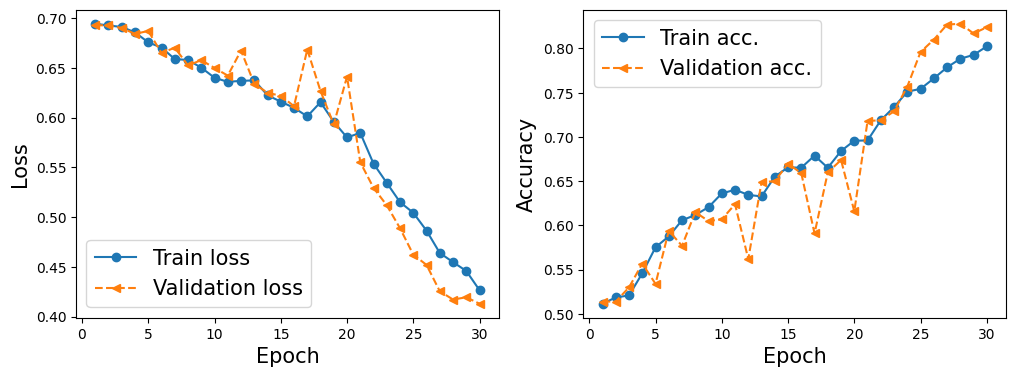

In [33]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_17.png', dpi=300)
plt.show()

Evaluate our trained model on the test dataset.

In [34]:
accuracy_test = 0

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        
        x_batch = x_batch.to(device) 
        y_batch = y_batch.to(device) 
        pred = model(x_batch)[:, 0]
        
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().cpu()

In [35]:
accuracy_test /= len(test_dl.dataset)
print(f'Test accuracy: {accuracy_test:.4f}') 

Test accuracy: 0.8352


In [36]:
len(x_batch)

506

In [37]:
pred = model(x_batch)[:, 0] * 100

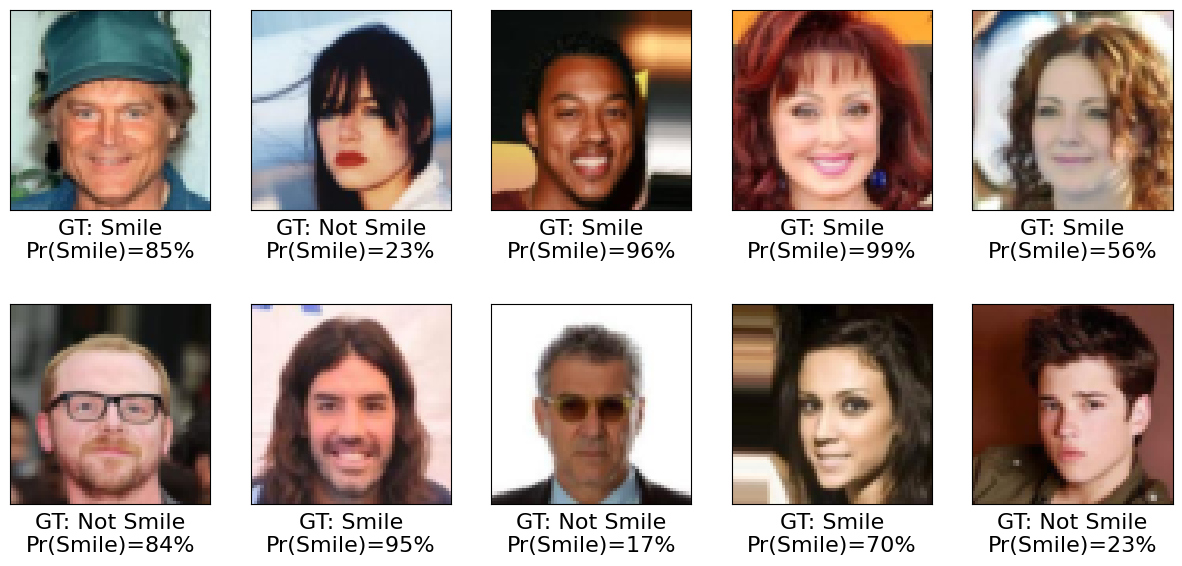

In [38]:
fig = plt.figure(figsize=(15, 7))

jStart = 10
jEnd = 20


for j in range(jStart, jEnd):
    
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([]) 
    ax.set_yticks([])
    
    
    imageIdx = j + 50
    ax.imshow(x_batch[imageIdx].cpu().permute(1, 2, 0))
    
    if y_batch[imageIdx] == 1:
        label = 'Smile'
    else:
        label = 'Not Smile'
        
    ax.text(
        0.5, -0.15, 
        f'GT: {label:s}\nPr(Smile)={pred[imageIdx]:.0f}%', 
        size=16, 
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
#plt.savefig('figures/figures-14_18.png', dpi=300)
plt.show()